# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.

Uncomment the following lines in Google Colab in order to install `scvi-tools`:

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import os
import tempfile

import pandas as pd
import scanpy as sc
import scvi
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.0.3


You can modify `save_dir` below to change where the data files for this tutorial are saved.

In [4]:
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


## Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [6]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")
model = scvi.model.AmortizedLDA(adata, n_topics=n_topics)

```{note}
By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.
```

In [7]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:40<00:00,  2.88it/s, v_num=1, elbo_train=1.86e+7]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [05:40<00:00,  2.93it/s, v_num=1, elbo_train=1.86e+7]


## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [8]:
topic_prop = model.get_latent_representation()
topic_prop.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AAACCCAAGATTGTGA-1,0.000188,0.037885,0.148025,0.000161,0.808256,0.004403,0.000129,0.000486,0.000289,0.000177
AAACCCACATCGGTTA-1,0.000206,0.000244,0.042489,0.000188,0.949140,0.004010,0.000092,0.000338,0.003173,0.000121
AAACCCAGTACCGCGT-1,0.000887,0.232126,0.195196,0.000731,0.560573,0.001700,0.002559,0.003135,0.002484,0.000607
AAACCCAGTATCGAAA-1,0.001437,0.001861,0.000900,0.000966,0.001105,0.001951,0.005143,0.001816,0.000643,0.984177
AAACCCAGTCGTCATA-1,0.000173,0.000321,0.000169,0.000107,0.000227,0.000313,0.000402,0.000174,0.000925,0.997188


In [9]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
    adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


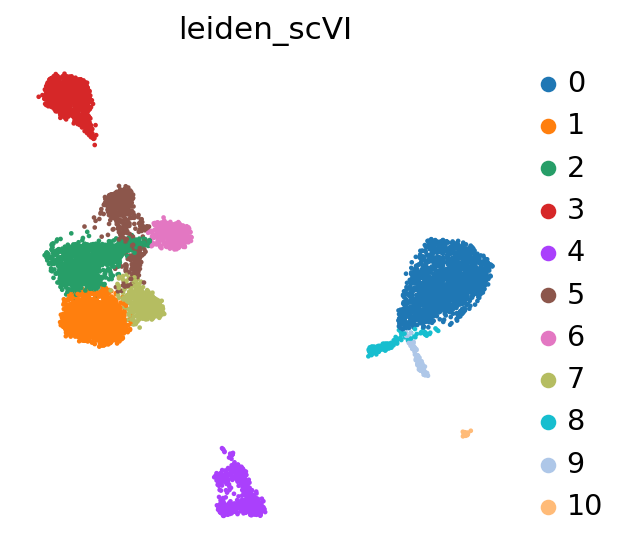

In [11]:
sc.pl.embedding(adata, "raw_counts_umap", color=["leiden_scVI"], frameon=False)

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

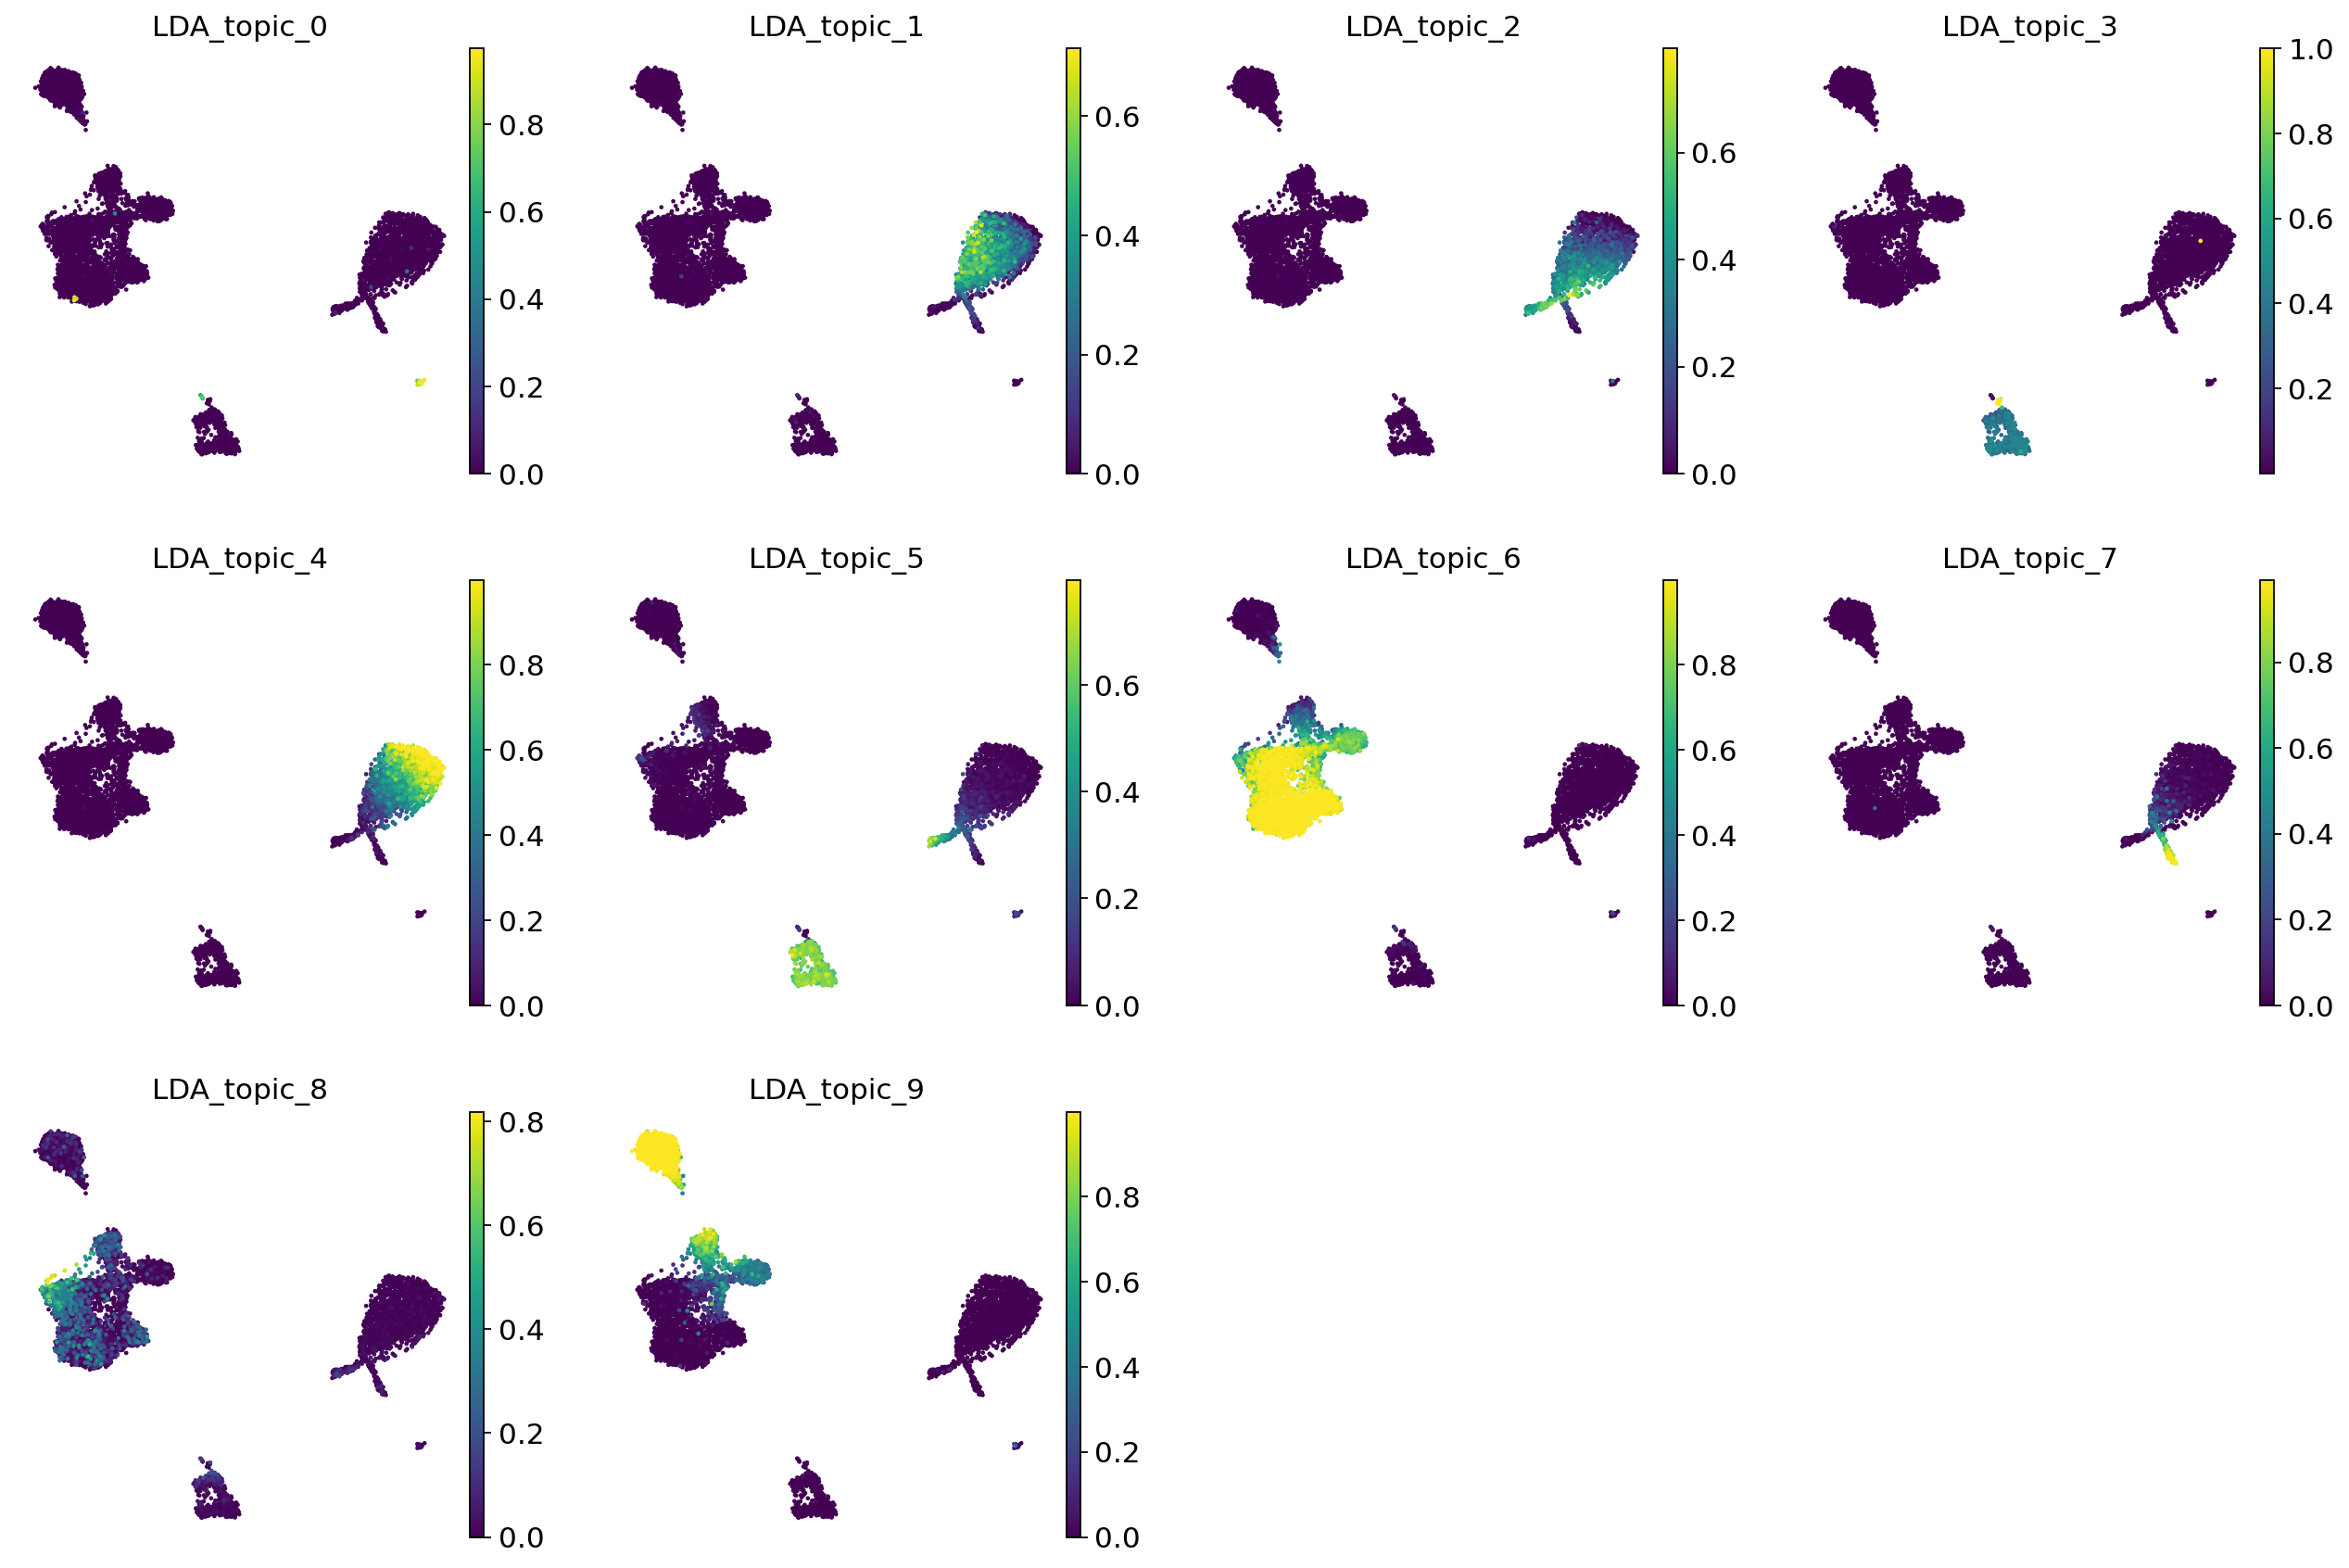

In [12]:
sc.pl.embedding(
    adata,
    "raw_counts_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Plot UMAP in topic space

In [13]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors=20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

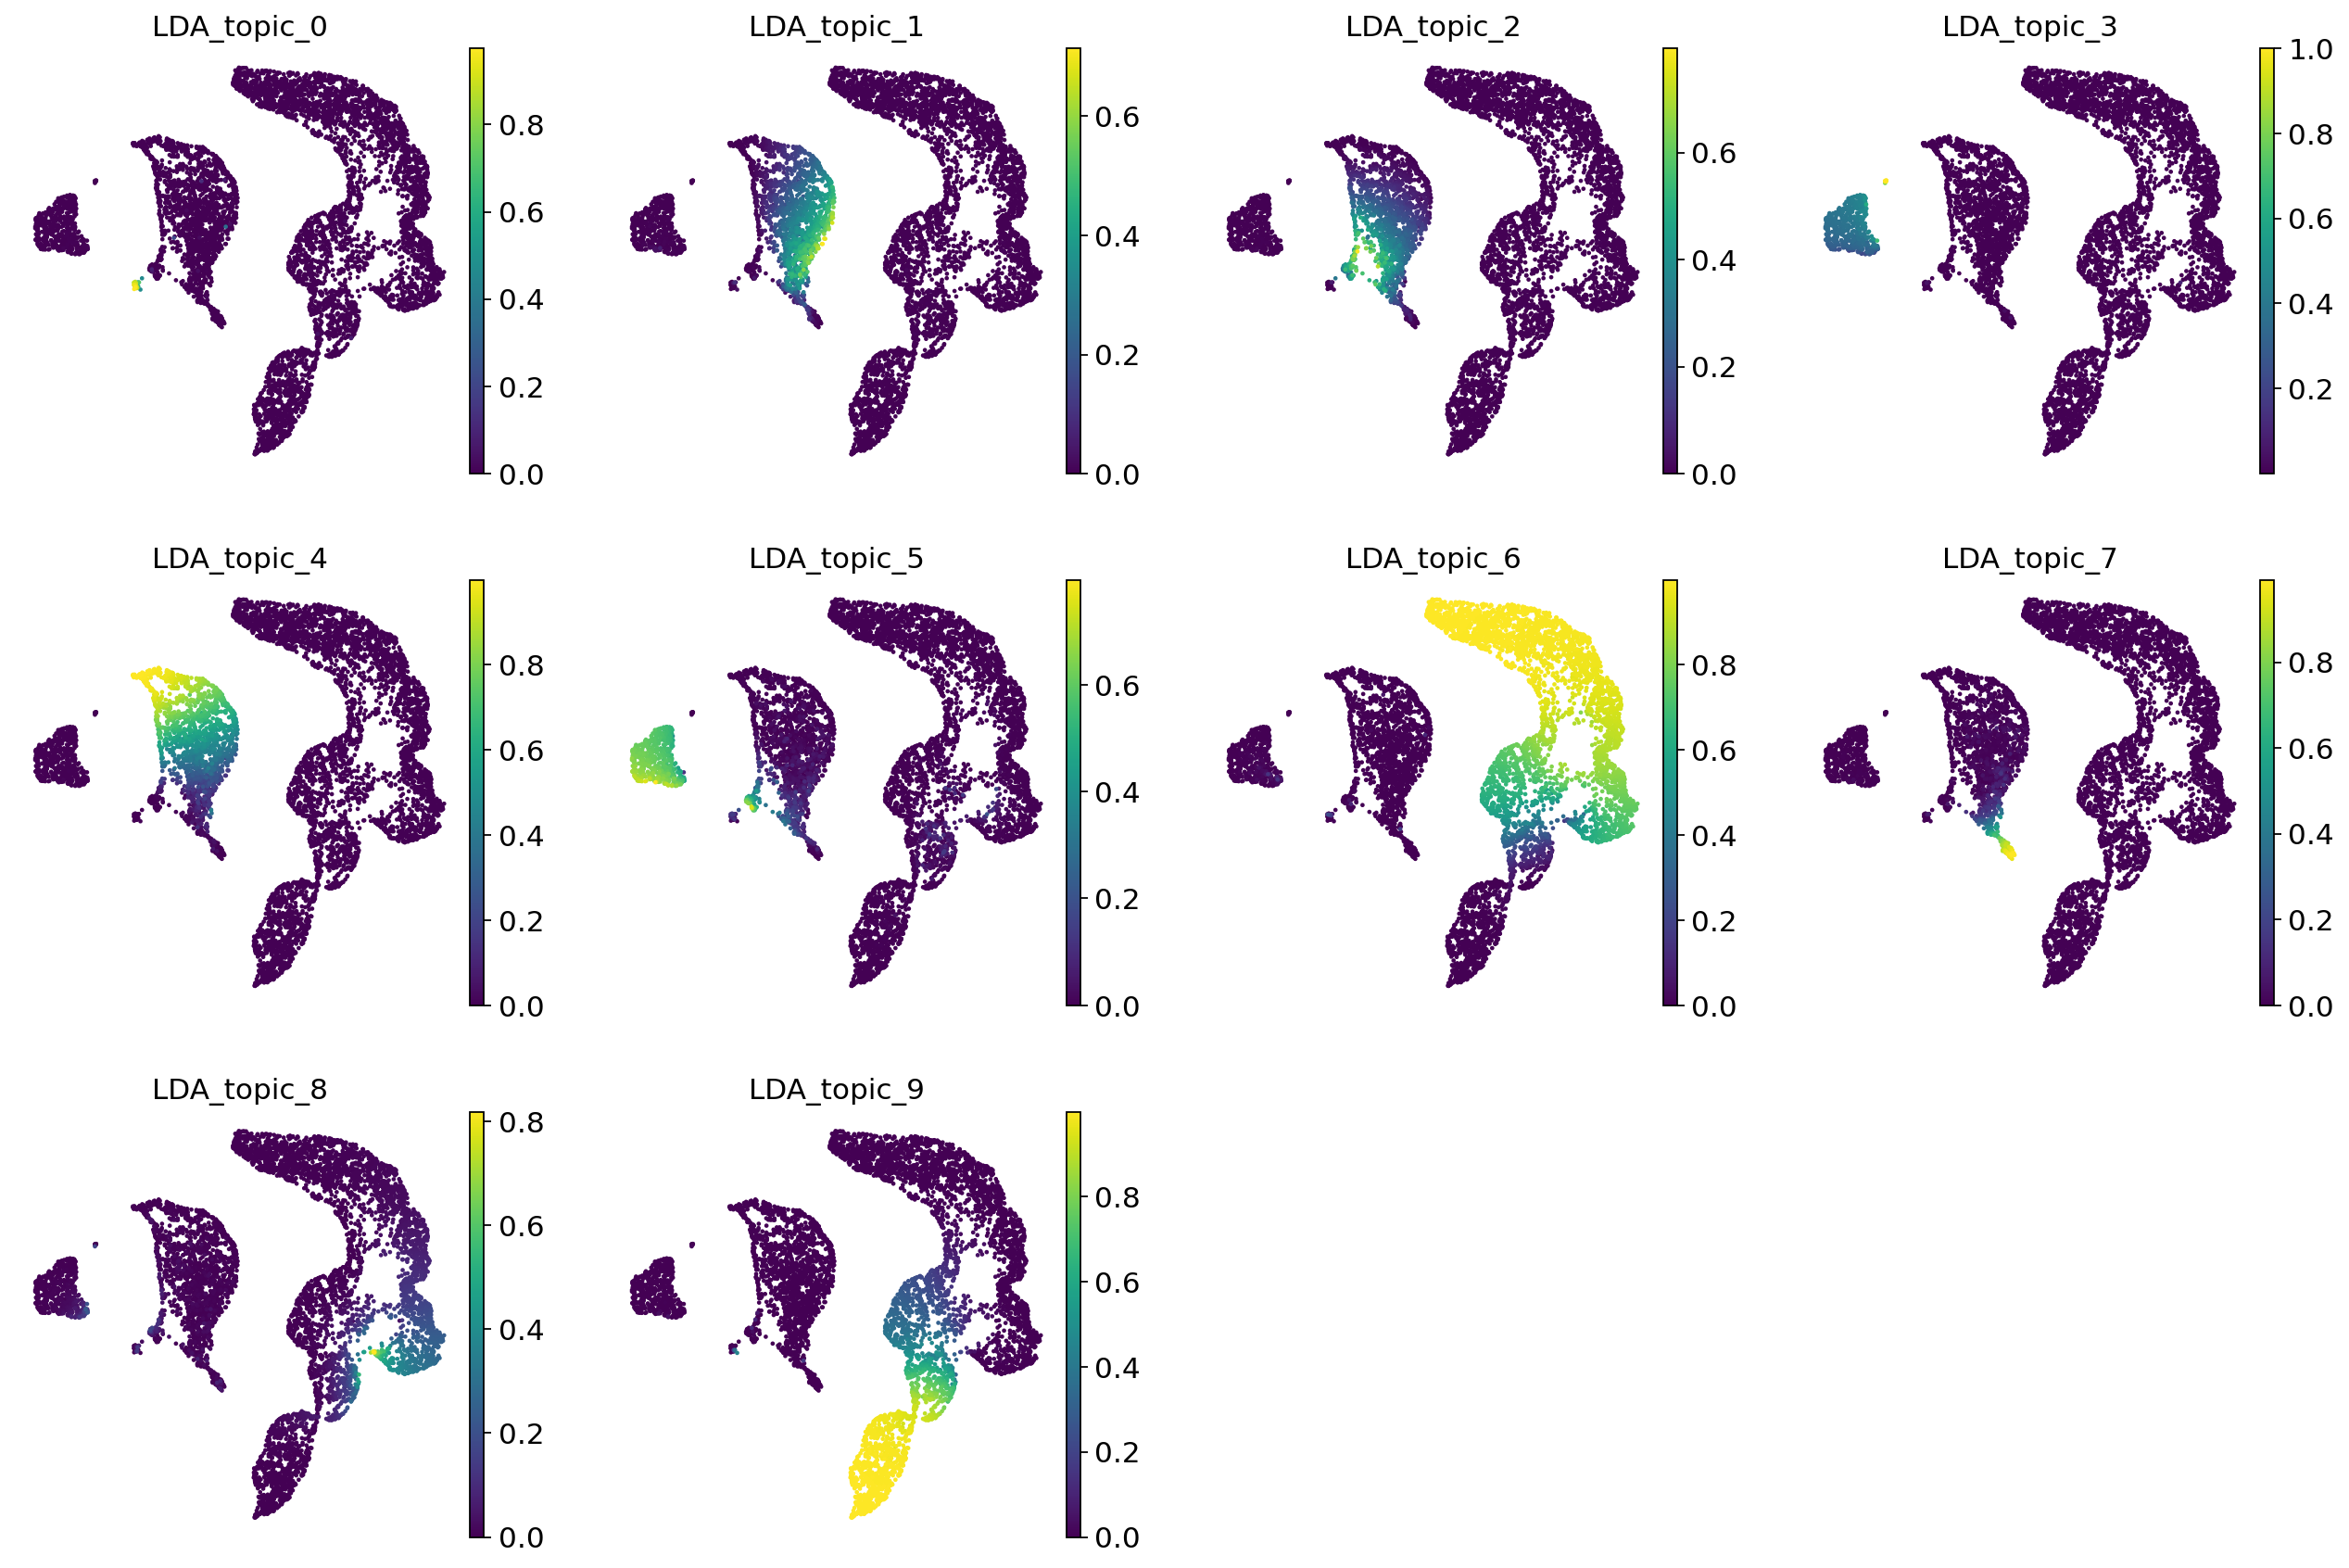

In [14]:
sc.pl.embedding(
    adata,
    "topic_space_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [15]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
index,,,,,,,,,,
AL645608.8,0.000018,0.000003,0.000002,0.000005,2.360189e-06,0.000003,0.000001,0.000033,0.000005,0.000002
HES4,0.000024,0.000006,0.000006,0.000010,8.129477e-06,0.000011,0.000007,0.000696,0.000008,0.000006
ISG15,0.000031,0.000879,0.000018,0.000197,2.258939e-04,0.000624,0.001139,0.000623,0.001597,0.001388
TNFRSF18,0.000147,0.000002,0.000001,0.000032,7.911760e-07,0.000006,0.000396,0.000003,0.000038,0.000131
TNFRSF4,0.000040,0.000002,0.000003,0.000007,1.579124e-06,0.000005,0.000834,0.000004,0.000048,0.000057


In [16]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [17]:
rank_by_topic.head()

,topic_0,topic_0_prop,topic_1,topic_1_prop,topic_2,topic_2_prop,topic_3,topic_3_prop,topic_4,topic_4_prop,topic_5,topic_5_prop,topic_6,topic_6_prop,topic_7,topic_7_prop,topic_8,topic_8_prop,topic_9,topic_9_prop
0,CD74,0.059290,FTH1,0.086838,LYZ,0.083449,IGKC,0.233030,S100A9,0.143519,CD74,0.156806,TMSB4X,0.126411,FTL,0.112751,ACTB,0.264263,TMSB4X,0.087633
1,ACTB,0.040588,FTL,0.073924,ACTB,0.057350,IGLC2,0.125259,S100A8,0.098891,HLA-DRA,0.113971,TMSB10,0.085176,ACTB,0.069703,TMSB4X,0.135907,ACTB,0.086186
2,TMSB4X,0.029750,TMSB4X,0.041812,CST3,0.035908,IGHA1,0.083673,LYZ,0.057798,TMSB4X,0.067430,ACTB,0.077509,TMSB4X,0.058746,TMSB10,0.094544,GNLY,0.070738
3,FTH1,0.025553,LYZ,0.037145,S100A4,0.027521,IGHM,0.056419,FTL,0.043597,HLA-DRB1,0.066456,JUNB,0.034766,FTH1,0.056941,ACTG1,0.087103,NKG7,0.054089
4,HLA-DRA,0.019603,NEAT1,0.029798,VIM,0.027337,IGLC3,0.039387,ACTB,0.038481,ACTB,0.046950,FTL,0.028121,S100A4,0.030024,S100A4,0.036098,CCL5,0.041511


## Clean up

Uncomment the following line to remove all data files created in this tutorial:

In [18]:
# save_dir.cleanup()